This kernal aims to explore Yelp reviews dataset and make actionable insights. It basically tries to answer following questions:

1. Which businesses are getting top reviews?
1. Which categories of business are getting top reviews?
1. How businesses are getting reviewed over time.
1. Are the categories of tending businesses different from top reviewed businesses? 
1. Which categories of businesses are new?
1. Which categories of businesses are getting bad reviews?
1. What are most common words in bad reviews?
1. Are reviews influenced by user's friends?


Terminology used:
1. __Top reviewed business__ : Business with most numbers of positive reviews
1. __Negatively reviewed business__ : Business with most numbers of negative reviews
1. __Trending business__ : Business with most number of reviews, with more than 4 stars in recent years
1. __Positive review__ : Review with more than 3 stars
1. __Negative review__ : Review with just 1 star

Lets import required packages and load data

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt

import collections
import re, string
import sys
import time
from nltk.corpus import stopwords
from wordcloud import WordCloud
from mpl_toolkits.basemap import Basemap

from subprocess import check_output
%matplotlib inline

In [2]:
import json

def init_ds(json):
    ds= {}
    keys = json.keys()
    for k in keys:
        ds[k]= []
    return ds, keys

def read_json(file):
    dataset = {}
    keys = []
    with open(file) as file_lines:
        for count, line in enumerate(file_lines):
            data = json.loads(line.strip())
            if count ==0:
                dataset, keys = init_ds(data)
            for k in keys:
                dataset[k].append(data[k])
                
        return pd.DataFrame(dataset)

In [3]:
%%time

yelp_tips = read_json('../input/yelp_academic_dataset_tip.json')

CPU times: user 12.3 s, sys: 948 ms, total: 13.2 s
Wall time: 13.2 s


In [4]:
%%time

yelp_review= read_json('../input/yelp_academic_dataset_review.json')

CPU times: user 1min 54s, sys: 12.2 s, total: 2min 6s
Wall time: 2min 7s


In [5]:
%%time

yelp_business= read_json('../input/yelp_academic_dataset_business.json')


CPU times: user 5.07 s, sys: 328 ms, total: 5.4 s
Wall time: 5.38 s


In [6]:
%%time

yelp_users = read_json('../input/yelp_academic_dataset_user.json')

CPU times: user 51.1 s, sys: 3.25 s, total: 54.3 s
Wall time: 54.3 s


In [7]:

yelp_review["date"]=  pd.to_datetime(yelp_review["date"], format='%Y-%m-%d')
yelp_review['year'] = yelp_review.date.dt.year

Lets see how data looks like

In [8]:
yelp_review.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,year
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA,2013
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg,2017
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw,2016
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg,2018
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ,2018


In [9]:
yelp_business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


In [10]:
yelp_users.head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,4.03,1,0,1,2,0,0,1,0,1,...,25,"2015,2016,2017",5,"c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",17,Rashmi,95,84,l6BmjZMeQD3rDxWUbiAiow,2013-10-08 23:11:33
1,3.63,1,0,1,1,0,0,0,0,0,...,16,,4,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",22,Jenna,33,48,4XChL029mKr5hydo79Ljxg,2013-02-21 22:29:06
2,3.71,0,0,0,0,0,0,1,0,0,...,10,,0,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",8,David,16,28,bc8C_eETBWL0olvFSJJd0w,2013-10-04 00:16:10
3,4.85,0,0,0,1,0,0,0,0,2,...,14,,5,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",4,Angela,17,30,dD0gZpBctWGdWo9WlGuhlA,2014-05-22 15:57:30
4,4.08,80,0,80,28,1,1,16,5,57,...,665,"2015,2016,2017,2018",39,"mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",279,Nancy,361,1114,MM4RJAeH6yuaN8oZDSt0RA,2013-10-23 07:02:50


Lets get the overview of reviews.

In [11]:
useful_reviews = len(yelp_review[yelp_review["useful"]>0])
cool_reviews = len(yelp_review[yelp_review["cool"]>0])
funny_reviews = len(yelp_review[yelp_review["funny"]>0])
negative_reviws = len(yelp_review[yelp_review["stars"]<2])
positive_reviews =len(yelp_review[yelp_review["stars"]>3])
total_reviews = len(yelp_review)

print("Total reviews: {}".format(total_reviews))
print("Useful reviews: {}".format(useful_reviews))
print("Funny reviews: {}".format(funny_reviews))
print("Cool reviews: {}".format(cool_reviews))
print("Total negative reviews: {}".format(negative_reviws))
print("Total positive reviews: {}".format(positive_reviews))


Total reviews: 6685900
Useful reviews: 3115446
Funny reviews: 1373727
Cool reviews: 1672612
Total negative reviews: 1002159
Total positive reviews: 4402067


# Top reviewed business

In [12]:
top_reviewed = yelp_review[yelp_review["stars"]>3]
top_reviews_dict ={}

for business_id in top_reviewed["business_id"].values:
    try :
        top_reviews_dict[business_id] =top_reviews_dict[business_id]+1
    except:
        top_reviews_dict[business_id]=1
        
topbusiness = pd.DataFrame.from_dict(data= top_reviews_dict,orient="index")

topbusiness.reset_index(inplace=True)
topbusiness.columns = ['business_id', 'rated']
del(top_reviews_dict)
del(top_reviewed)

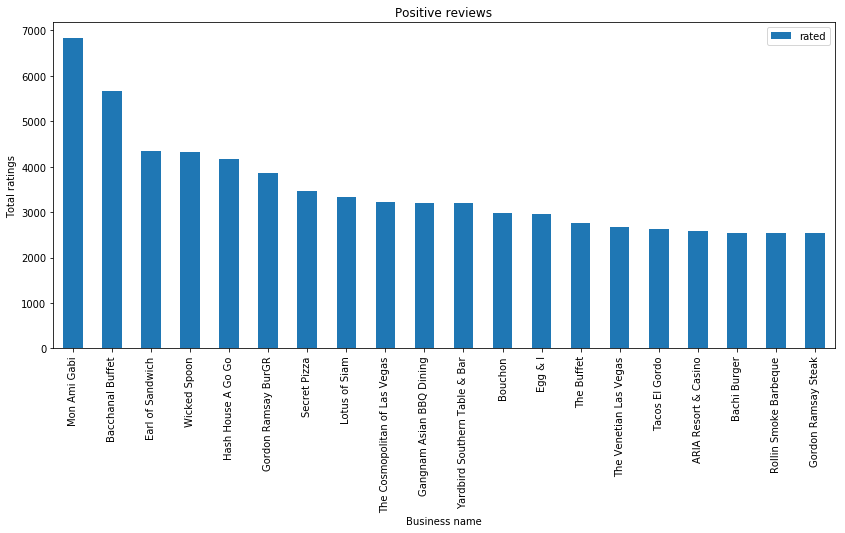

In [13]:
top_count= 20
right=pd.DataFrame(yelp_business[['business_id',"name","categories"]].values,
                    columns=['business_id',"Business name","categories"])

top_business_data = pd.merge(topbusiness,right=right, how="inner",on='business_id')
top_business_data.sort_values("rated")[::-1][:top_count].plot(x="Business name",y="rated", 
                                                   kind="bar",figsize=(14,6),
                                                   title='Positive reviews').set_ylabel("Total ratings")

del(topbusiness)
del(right)

# What are the locations of top reviewed businesses

Generally customers are eager to know what are the locations of best business outlets etc. In this section we will find locations of top best reviwed business locations and show in map.

In [14]:
num_business = 300
business_ids = top_business_data.sort_values("rated")[::-1][:num_business].business_id.values
#len(business_ids)
useful_b = yelp_business.loc[yelp_business['business_id'].isin(business_ids)]

#len(useful_b)

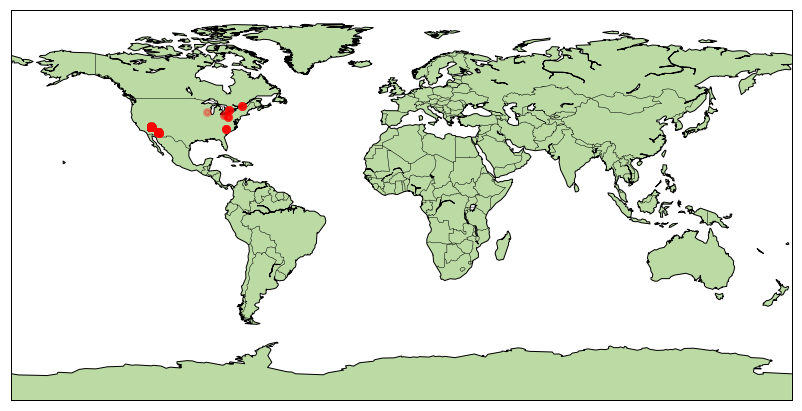

In [15]:
fig = plt.figure(figsize=(14, 8), edgecolor='w')

m = Basemap(projection='cyl',llcrnrlon= -180, urcrnrlon = 180,
            llcrnrlat = -90, urcrnrlat= 90,resolution='c',
           lat_ts = True)
m.drawcoastlines()
m.fillcontinents(color='#bbdaa4',lake_color='#FFFFFF')
m.drawcountries()
m.drawmapboundary(fill_color='#FFFFFF')

mloc = m(useful_b['latitude'].tolist(),useful_b['longitude'].tolist())
m.scatter(mloc[1],mloc[0],color ='red',lw=3,alpha=0.3,zorder=5)

# How businesses are getting reviewed over time


Some businesses try to maintain their overall quality standards and make their customers happy. Lets see which businesses are maintaining their quality standards  based on positive reviews.

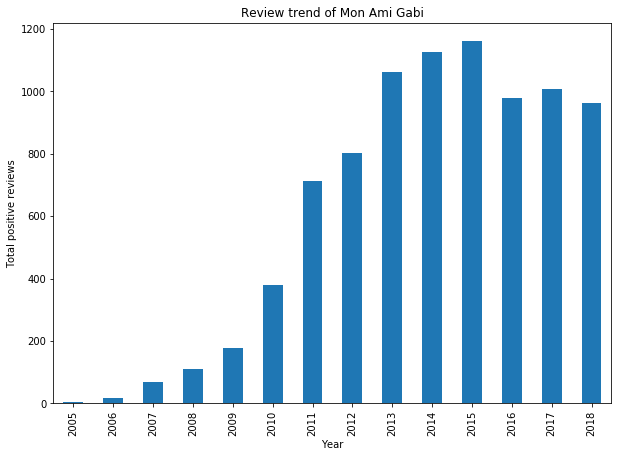

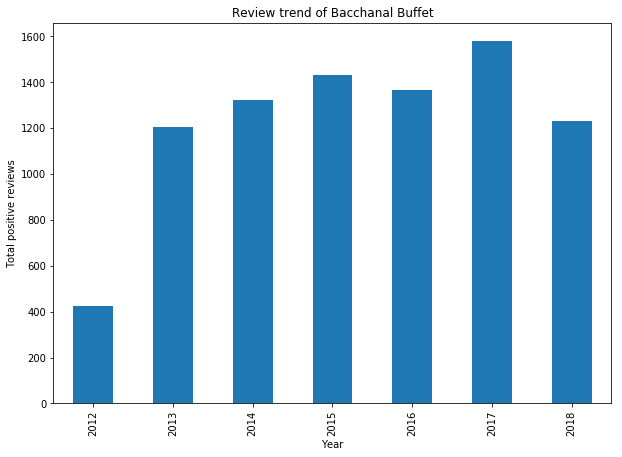

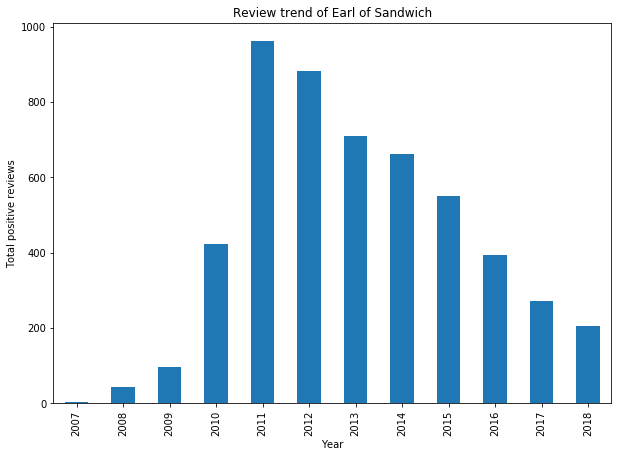

In [16]:
num_business = 3
business_ids = top_business_data.sort_values("rated")[::-1][:num_business].business_id.values
business_names = top_business_data.sort_values("rated")[::-1][:num_business]["Business name"].values
for i, business_id in enumerate(business_ids):
    useful_b = yelp_review.loc[yelp_review['business_id'] == business_id]
    useful_b = useful_b.groupby(['year']).size().reset_index(name='counts')
    #print(useful_b.head())
    series = pd.Series(useful_b["counts"].values, index=useful_b["year"].values, name='Review trend')
    axes = series.plot(kind="bar",figsize=(10, 7))
    plt.xlabel('Year', axes=axes)
    plt.ylabel('Total positive reviews', axes=axes)
    plt.title('Review trend of {}'.format(business_names[i]), axes=axes)
    plt.show()


Based on above graphs one can see that positive reviews of "Earl of Sandwich" is dropping this can mean either people are not visiting "Earl of Sandwich" or quality standards of this business is definitely dropping over time.

Anyone can explore more information by increasing value of `num_business`.

# Most recent Trending businesses

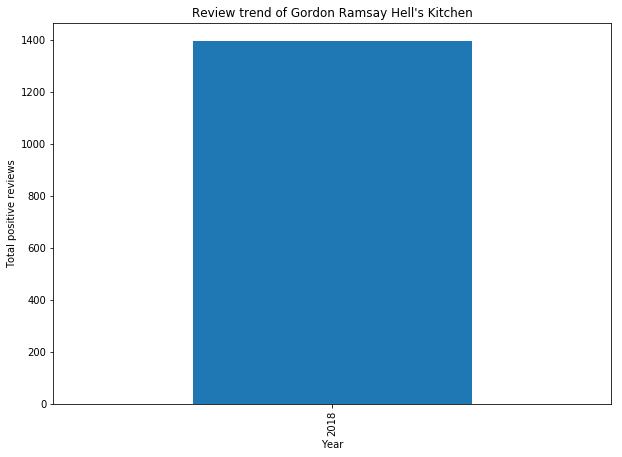

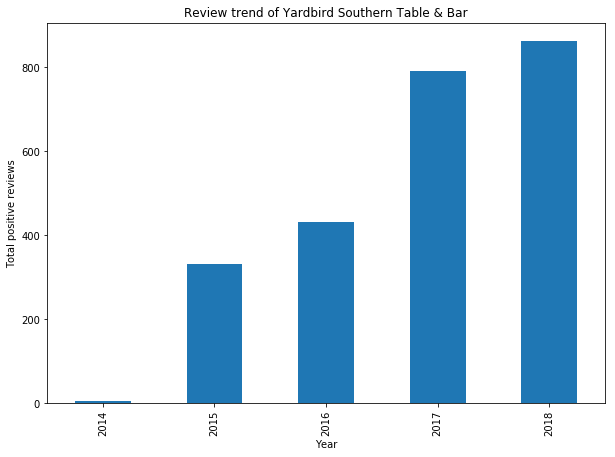

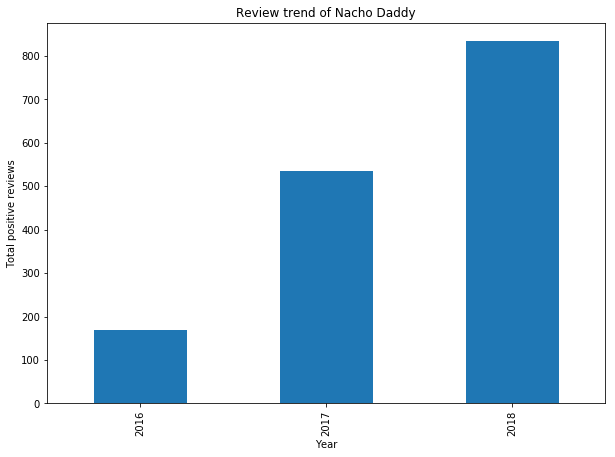

In [17]:
top_business = 3
temp = yelp_review[["business_id",'year',"stars"]]
five_star_reviews = temp[temp["stars"]>4]
trending_business_reviews = five_star_reviews.groupby(["business_id",'year']).size().reset_index(name='counts')

trending = trending_business_reviews.sort_values(['year','counts'])[::-1][:top_business].business_id.values
for  business_id in trending:
    record = trending_business_reviews.loc[trending_business_reviews['business_id'] == business_id]
    business_name = yelp_business.loc[yelp_business['business_id'] == business_id].name.values[0]
    series = pd.Series(record["counts"].values, index=record.year.values, name='Trending business')
    axes = series.plot(kind="bar",figsize=(10, 7))
    plt.xlabel('Year', axes=axes)
    plt.ylabel('Total positive reviews', axes=axes)
    plt.title('Review trend of {}'.format(business_name), axes=axes)
    plt.show()
    #len(trending_business_reviews)

From above graphs one can easliy see that "Yardbird southern table & bar" is new commer in business and has got most reviews in year 2017. And "Mon Ami Gabi" is able to maintain it reviews which indicate persistant quality standards.

Anyone can explore more insights by changing value of `top_business`.

# Categories of top reviewed businesses

This section can answer the question "What categories of businesses are at succeeding?" Good reviews means customers are happy to visit and take time to write reviews.

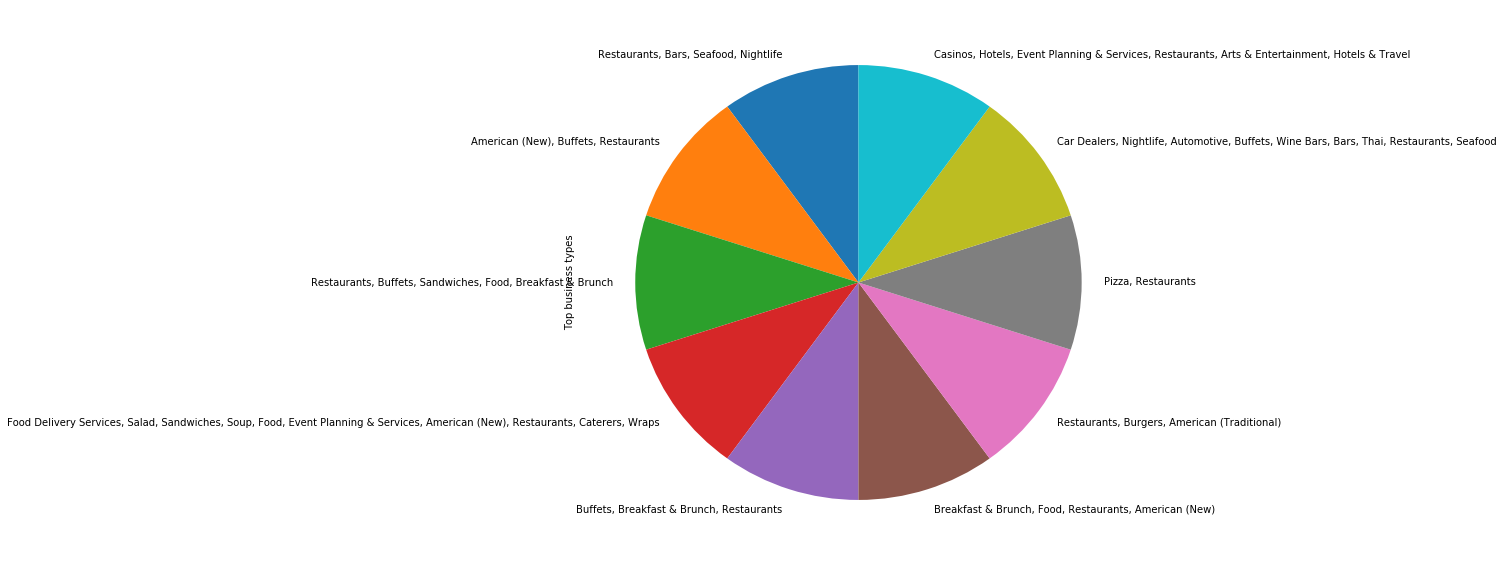

In [18]:
num_cat =10 # to show top 10 catrgories
top_business = 30 # choose categories of top 30 businesses
cat_data = top_business_data.sort_values("rated")[::-1][:top_business]
#cat_data.categories
Categories={}
for cat in cat_data.categories.values:
    all_categories= cat.split(";")
    for x in all_categories:
        try :
            Categories[x] =Categories[x]+1
        except:
            Categories[x]=1
top_categories = pd.DataFrame.from_dict(data= Categories,orient="index")
top_categories.reset_index(inplace=True)
top_categories.columns = ['category', 'occurance']

x_val=top_categories.sort_values("occurance")[::-1][:num_cat].occurance.values
labels=top_categories.sort_values("occurance")[::-1][:num_cat].category.values
series = pd.Series(x_val, index=labels, name='Top business types')
series.plot.pie(figsize=(10, 10),startangle=90)



Anyone interested in getting more categories can change  value of `num_cat` and `top_business`.

# Categories of trending businesses

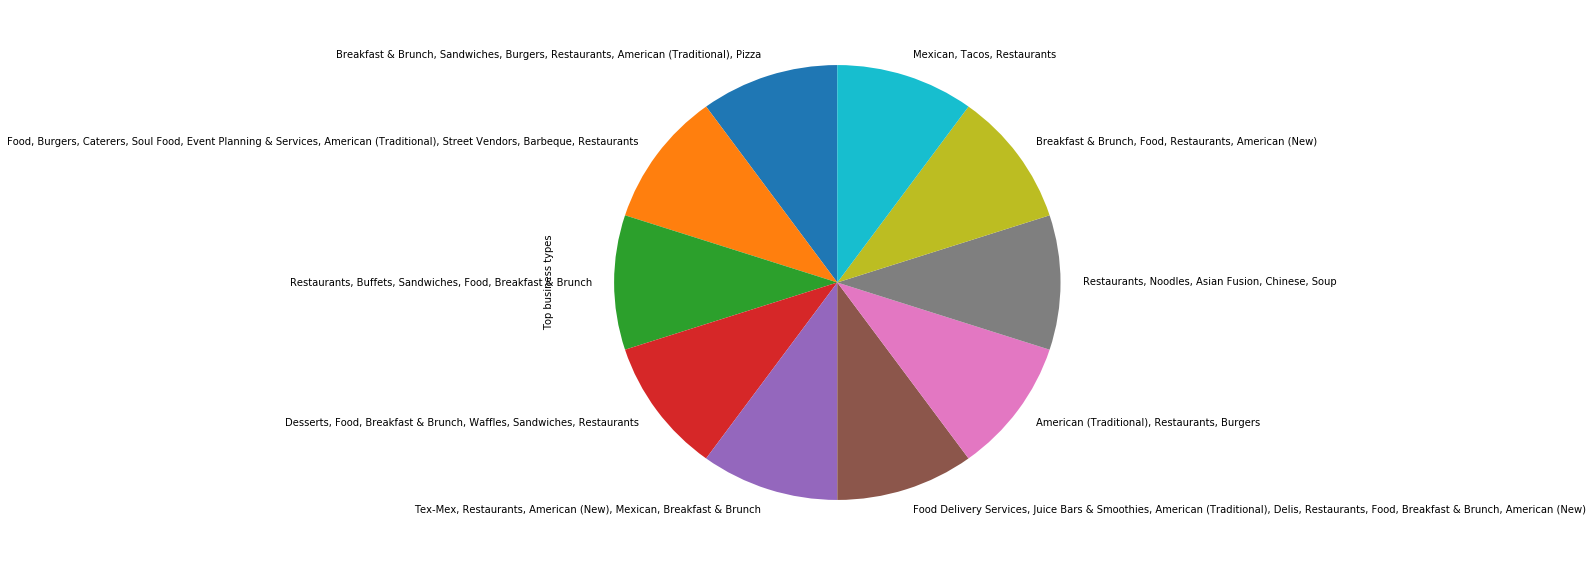

In [19]:
num_cat =10 # to show top 10 catrgories
top_business = 40 # choose categories of top 30 businesses
business_ids = trending_business_reviews.sort_values(['year','counts'])[::-1][:top_business].business_id.values
cat_data = top_business_data.loc[top_business_data['business_id'].isin(business_ids)]
#cat_data.categories
Categories={}
for cat in cat_data.categories.values:
    all_categories= cat.split(";")
    for x in all_categories:
        try :
            Categories[x] =Categories[x]+1
        except:
            Categories[x]=1
top_categories = pd.DataFrame.from_dict(data= Categories,orient="index")
top_categories.reset_index(inplace=True)
top_categories.columns = ['category', 'occurance']

x_val=top_categories.sort_values("occurance")[::-1][:num_cat].occurance.values
labels=top_categories.sort_values("occurance")[::-1][:num_cat].category.values
series = pd.Series(x_val, index=labels, name='Top business types')
series.plot.pie(figsize=(10, 10),startangle=90)


By comparing above two pie chart one can say "Art and Entertaintment" is not a trending category of business to invest on. "Sandwitches" and "Mexican" are becoming more trending categories.

Anyone interested in getting more insights can change  value of `num_cat` and `top_business` in above code.

# Negatively reviewed businesses

In [20]:
bottom_reviewed = yelp_review[yelp_review["stars"]<2]
bottom_reviews_dict ={} 

for business_id in bottom_reviewed["business_id"].values:
    try :
        bottom_reviews_dict[business_id] =bottom_reviews_dict[business_id]+1
    except:
        bottom_reviews_dict[business_id]=1
        
bottombusiness = pd.DataFrame.from_dict(data= bottom_reviews_dict,orient="index")

bottombusiness.reset_index(inplace=True)
#bottombusiness.head()
bottombusiness.columns = ['business_id', 'rated']

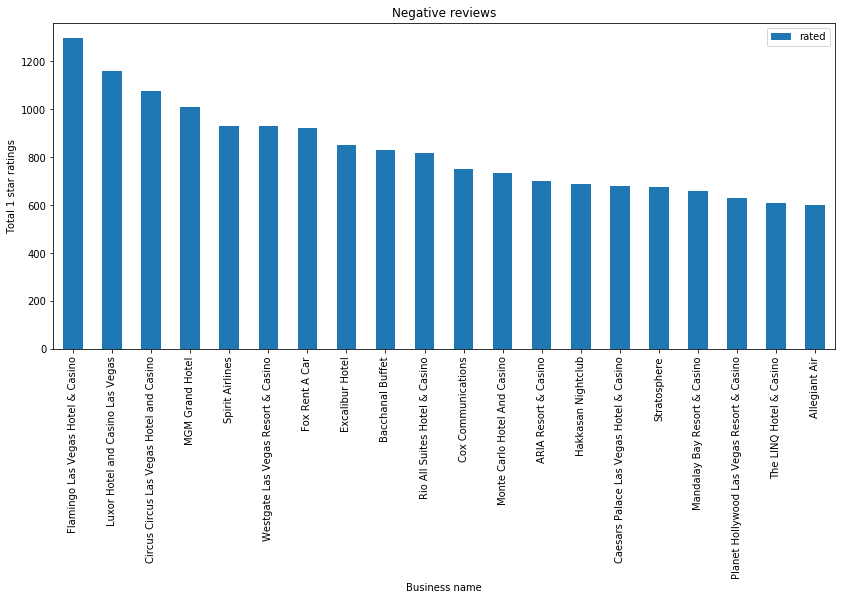

In [21]:
top_count= 20
right=pd.DataFrame(yelp_business[['business_id',"name","categories"]].values,
                    columns=['business_id',"Business name","categories"])

bottom_business_data = pd.merge(bottombusiness,right=right, how="inner",on='business_id')
bottom_business_data.sort_values("rated")[::-1][:top_count].plot(x="Business name",y="rated", 
                                                   kind="bar",figsize=(14,6),
                                                   title='Negative reviews').set_ylabel("Total 1 star ratings")

del(bottom_reviewed)
del(bottom_reviews_dict)
del(bottombusiness)
del(right)


Above plot shows that most of the "Casino" are negatively reviewed.

Anyone interested in getting more categories can change  value of `top_count`.

# Business categories which needs improvement

The categories of businesses which which are getting negative reviews definitely need to improve their services. Or this insight can be used by their competitors to start new business nearby.

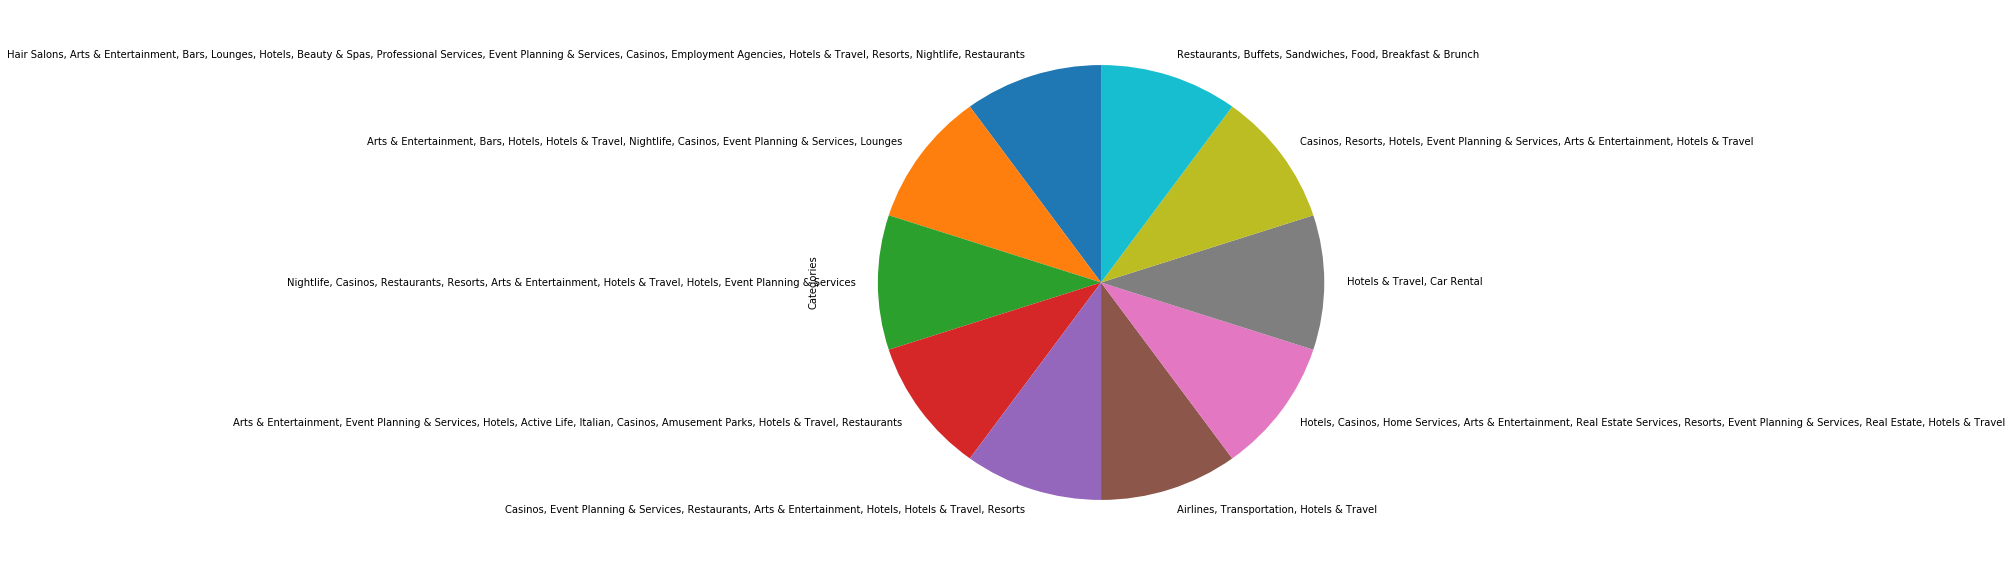

In [22]:
num_cat =10 # to show top 10 catrgories
bottom_business = 30 # choose categories of top 30 businesses
cat_data = bottom_business_data.sort_values("rated")[::-1][:bottom_business]

Categories={}
for cat in cat_data.categories.values:
    all_categories= cat.split(";")
    for x in all_categories:
        try :
            Categories[x] =Categories[x]+1
        except:
            Categories[x]=1
bottom_categories = pd.DataFrame.from_dict(data= Categories,orient="index")
bottom_categories.reset_index(inplace=True)
bottom_categories.columns = ['category', 'occurance']

x_val=bottom_categories.sort_values("occurance")[::-1][:num_cat].occurance.values
labels=bottom_categories.sort_values("occurance")[::-1][:num_cat].category.values
series = pd.Series(x_val, index=labels, name='Categories')
series.plot.pie(figsize=(10, 10),startangle=90)




Anyone interested in getting more categories can change  value of `num_cat` and `bottom_business`.

# Lets find most frequent words in Negative reviews


Basically, we will find most frequent words in reviews to get an overview of why users gave low ratings. These words could be related to those business attributes or services about which users are most unhappy.

In [23]:
# these are helper functions 
# directly copied from https://gist.github.com/benhoyt/dfafeab26d7c02a52ed17b6229f0cb52

def tokenize(s):
    """Convert string to lowercase and split into words (ignoring
    punctuation), returning list of words.
    """
    word_list = re.findall(r'\w+', s.lower())
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    return filtered_words


def count_ngrams(lines, min_length=2, max_length=4):
    """Iterate through given lines iterator (file object or list of
    lines) and return n-gram frequencies. The return value is a dict
    mapping the length of the n-gram to a collections.Counter
    object of n-gram tuple and number of times that n-gram occurred.
    Returned dict includes n-grams of length min_length to max_length.
    """
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    # Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

    # Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

    # Make sure we get the n-grams at the tail end of the queue
    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams

def print_most_frequent(ngrams, num=10):
    """Print num most common n-grams of each length in n-grams dict."""
    for n in sorted(ngrams):
        print('----- {} most common {}-word phrase -----'.format(num, n))
        for gram, count in ngrams[n].most_common(num):
            print('{0}: {1}'.format(' '.join(gram), count))
        print('')

def print_word_cloud(ngrams, num=5):
    """Print word cloud image plot """
    words = []
    for n in sorted(ngrams):
        for gram, count in ngrams[n].most_common(num):
            s = ' '.join(gram)
            words.append(s)
            
    cloud = WordCloud(width=1440, height= 1080,max_words= 200).generate(' '.join(words))
    plt.figure(figsize=(20, 15))
    plt.imshow(cloud)
    plt.axis('off');
    plt.show()
    print('')
    
            

Analysing business:  Flamingo Las Vegas Hotel & Casino
----- 10 most common 2-word phrase -----
front desk: 789
las vegas: 468
go room: 455
customer service: 403
resort fee: 306
go rooms: 220
stay flamingo: 207
stayed flamingo: 206
strip view: 202
middle strip: 197

----- 10 most common 3-word phrase -----
called front desk: 130
non smoking room: 87
right middle strip: 67
room strip view: 51
flat screen tv: 48
flamingo las vegas: 44
call front desk: 42
called guest services: 38
view high roller: 37
spend much time: 37



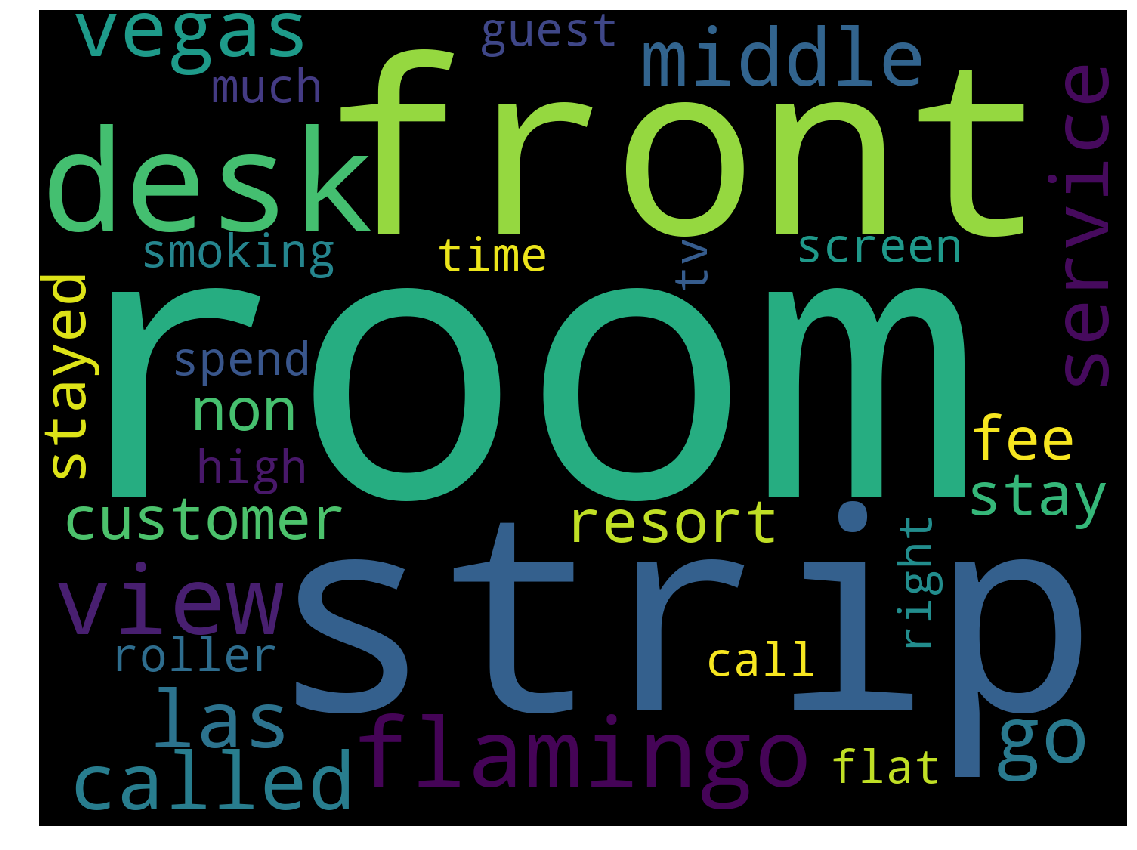

In [24]:
num_business_analysis = 1 # basically this will tell how much computing and diverse our analysis will be
business_ids=bottom_business_data.sort_values("rated")[::-1][:num_business_analysis].business_id.values
business_names = bottom_business_data.sort_values("rated")[::-1][:num_business_analysis]["Business name"].values
# get all the reviews and analyse them
#business_names
for i, business_id in enumerate(business_ids):
    # now extract reviews from reviews data
    print("Analysing business: ",business_names[i])
    reviews = yelp_review.loc[yelp_review['business_id'] == business_id].text.values
    most_used_text = count_ngrams(reviews,max_length=3)
    print_most_frequent(most_used_text, num=10)
    print_word_cloud(most_used_text, 10)
    #print ("total reviews ",len(reviews))
    

From above image one can easily understand there are some problems related to front desk, room service, customer service tv screen. This plot doesnt make a lot of sense but still, it gives an overview of most used words in reviews about which users are unhappy.

From business point of view this insight is very useful and business owners can easily use this information to improve their services.

Anyone interested in more insights can change `num_business_analysis`.

# Most frequent tips


Using both reviews and tips data, business can work on improving the specific areas of their business. Lets see if tips are really useful for insights.

Analysing business:  Flamingo Las Vegas Hotel & Casino
----- 10 most common 2-word phrase -----
go room: 11
total rewards: 11
customer service: 9
go rooms: 8
great location: 7
parking lot: 6
check line: 5
nathan burton: 5
early check: 5
pool party: 5

----- 10 most common 3-word phrase -----
total rewards card: 4
great customer service: 3
boyz ii men: 2
smells like vanilla: 2
get go room: 2
join total rewards: 2
strip view go: 2
great location go: 2
self check kiosks: 2
go rooms great: 2

----- 10 most common 4-word phrase -----
go big go home: 2
back work sleep necessary: 2
work sleep necessary yet: 2
get total rewards card: 2
6pm daily 5 cents: 2
daily 5 cents miller: 2
5 cents miller lite: 2
cents miller lite beer: 2
miller lite beer snob: 2
lite beer snob says: 2



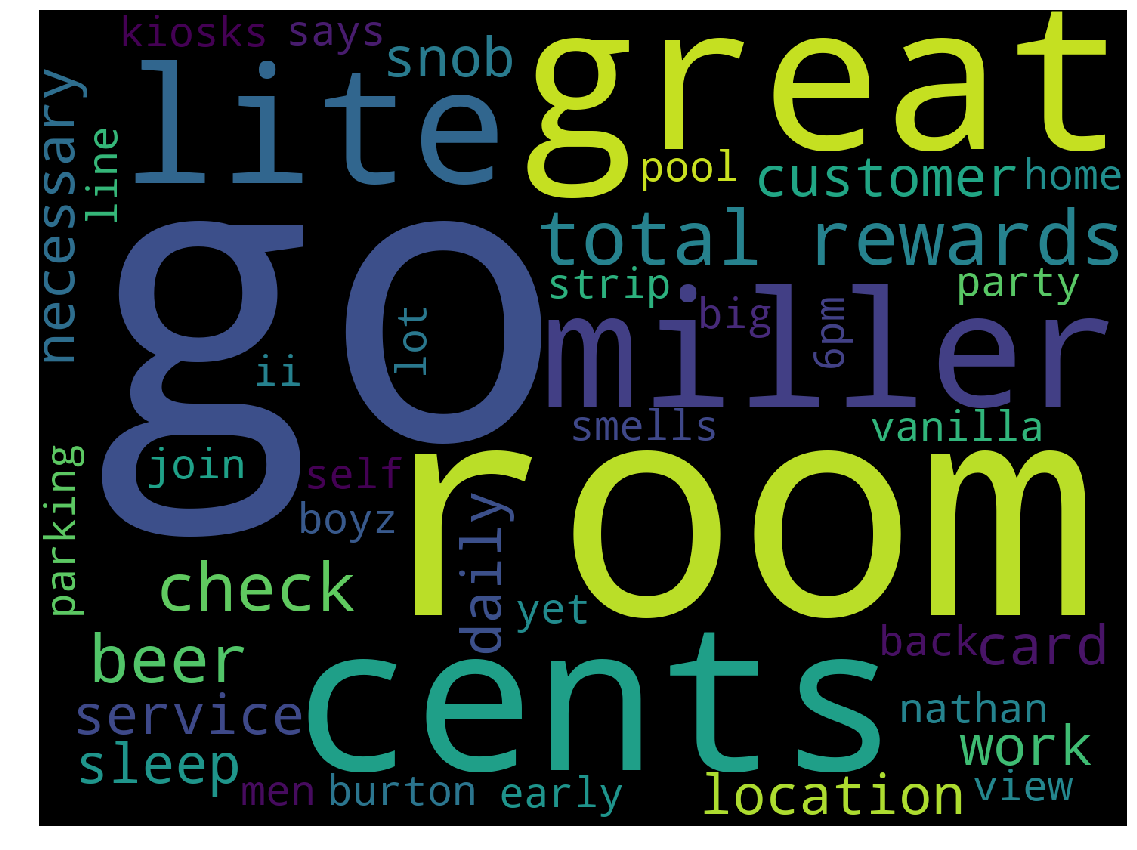


Analysing business:  Luxor Hotel and Casino Las Vegas
----- 10 most common 2-word phrase -----
paying bills: 20
work ten: 20
busy night: 18
grave shift: 16
good nite: 12
steve work: 12
long 10: 11
busy nite: 10
las vegas: 9
resort fee: 9

----- 10 most common 3-word phrase -----
grave shift rocks: 7
work ten busy: 6
steve aka neck: 6
half way threw: 6
way threw shift: 6
steve work ten: 5
happy new year: 5
work long 10: 4
holler ur boy: 4
work paying bills: 4

----- 10 most common 4-word phrase -----
half way threw shift: 6
grave shift rocks steve: 4
holler ur boy steve: 3
go big go home: 2
night grave shift rocks: 2
paying bills steve hey: 2
work ten busy start: 2
friends steve aka neck: 2
aka neck paying bills: 2
steve half way threw: 2



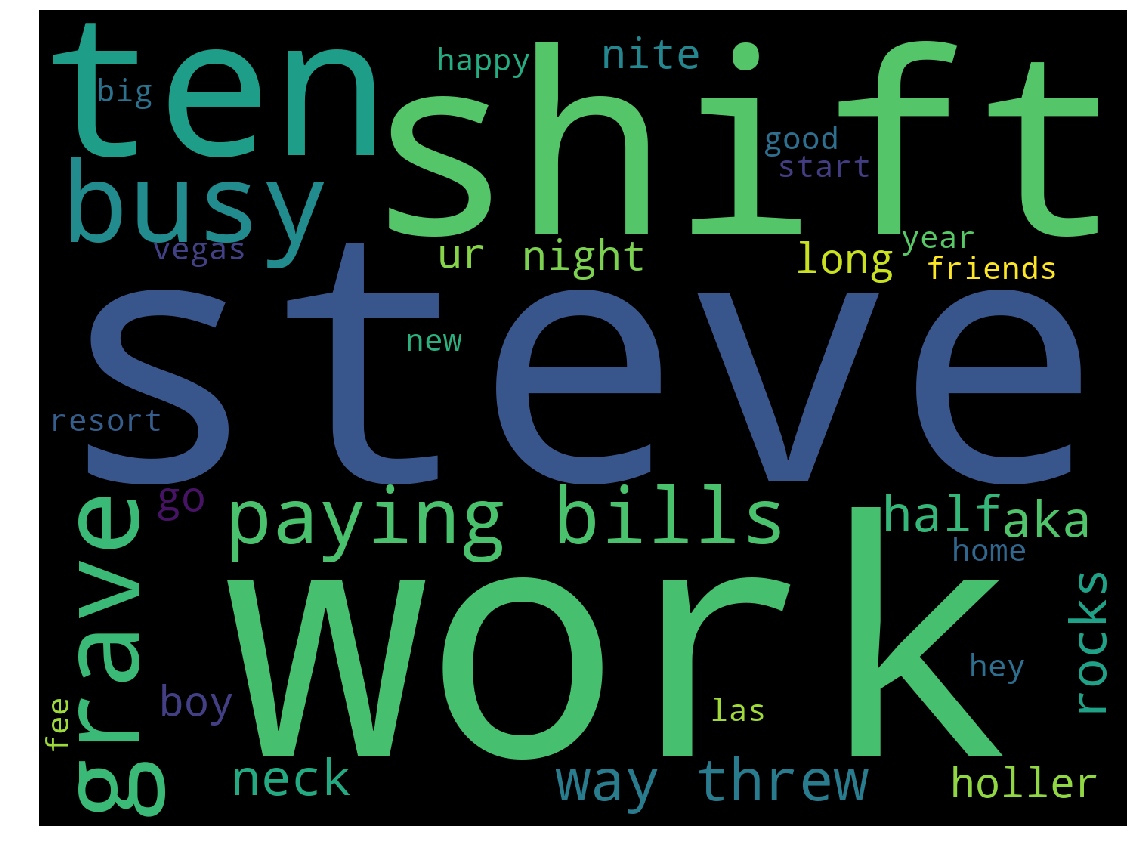

In [25]:
num_business_analysis = 2 # basically this will tell how much computing and diverse our analysis will be
business_ids=bottom_business_data.sort_values("rated")[::-1][:num_business_analysis].business_id.values
business_names = bottom_business_data.sort_values("rated")[::-1][:num_business_analysis]["Business name"].values
# get all the reviews and analyse them
#business_names
for i, business_id in enumerate(business_ids):
    # now extract reviews from reviews data
    print("Analysing business: ",business_names[i])
    reviews = yelp_tips.loc[yelp_tips['business_id'] == business_id].text.values
    most_used_text = count_ngrams(reviews,max_length=4)
    print_most_frequent(most_used_text, num=10)
    print_word_cloud(most_used_text, 10)
    #print ("total reviews ",len(reviews))

Tips seem very random and unuseful for business as these contains basic greetings and more general phrases like "paying bills" "busy night".

# Lets find relationship between users's friends and review patterns

In [26]:
top_users = 15
user_most_reviews = yelp_review.groupby(['user_id']).size().reset_index(name='counts')
top_users_ids = user_most_reviews.sort_values(['counts'])[::-1][:top_users].user_id.values

In [27]:
user_frnds = {}
for  users_id in top_users_ids:
    
    record = yelp_users.loc[yelp_users['user_id'] == users_id]
    user_frnds[users_id] = {}
    user_frnds[users_id]["name"]= record.name.values[0]
    user_frnds[users_id]["friends"]= record.friends.values[0]
    if record.friends is not "None":
        user_frnds[users_id]["friends_count"]= len(record.friends.values[0].split(","))
    else:
        user_frnds[users_id]["friends_count"]=0
    user_frnds[users_id]["review_count"]=record.review_count.values[0]
    user_frnds[users_id]["fans"]=record.fans.values[0]

In [28]:
 user_friend_df = pd.DataFrame.from_dict(data= user_frnds,orient="index")

In [29]:
user_friend_df.head()

,name,friends,friends_count,review_count,fans
62GNFh5FySkA3MbrQmnqvg,Chad,"68HjN_1C3Us_smf78s1eTg, -GNRfTJWgLmJu1jincRJyg...",413,2410,150
CxDOIDnH8gp9KXzpBHJYXw,Jennifer,"mrru6hbeQLvagU4vkfuqmw, wt0lL3xJIGeJ1r0qO-vkrg...",562,6314,715
DK57YibC5ShBmqQl97CKog,Karen,"_tDb7UEeJS623b8RTjSIvg, v0JtfrbTDNPvSp3rXv8IRg...",1186,2340,411
ELcQDlf69kb-ihJfxZyL0A,Brad,"MM4RJAeH6yuaN8oZDSt0RA, HP_UkrcE_ILzQ-BB_R-cEA...",275,1642,69
PKEzKWv_FktMm2mGPjwd0Q,Norm,"9h3GjDZbkD0pQsx-e-gr0A, 6iNeElU0lFkKdBu3wAzEBw...",1247,2421,283


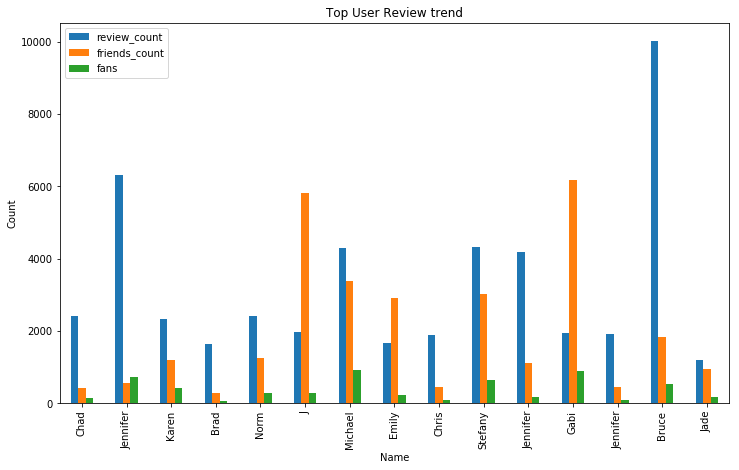

In [30]:
axes = user_friend_df.plot(x="name", y=["review_count", "friends_count", "fans"],
                           kind="bar",figsize=(12, 7))
plt.xlabel('Name', axes=axes)
plt.ylabel('Count', axes=axes)
plt.title('Top User Review trend'.format(business_name), axes=axes)
plt.show()

From above graph we can see there is no defined relashionship between user's fans, friends and review count. User reviewing for a business totally depends on user's character and/or satisfaction with business services.

# Does user's friends infulence business review?

Lets find trending business and its top users. Then we will cross check with yelp user database if a particular user's friend also has given rating to that business or not.

In [31]:
business_rank = 4 # 0 to 9
temp = yelp_review[["business_id",'year',"stars"]]
five_star_reviews = temp[temp["stars"]>4]
trending_business_reviews = five_star_reviews.groupby(["business_id",'year']).size().reset_index(name='counts')

business_id = trending_business_reviews.sort_values(['year','counts'])[::-1][:10].business_id.values[business_rank]
business_name = yelp_business.loc[yelp_business['business_id'] == business_id].name.values[0]

In [32]:
user_reviws = yelp_review.loc[yelp_review['business_id']==business_id]
topuser_reviws = user_reviws.groupby(['user_id']).size().reset_index(name='counts')
print("Total users who gave ratings to {} are {}".format(business_name,len(topuser_reviws)))

Total users who gave ratings to The Sicilian Butcher are 862


In [33]:
top_users = 50 #len(topuser_reviws)// 10
topuser_reviws = topuser_reviws.sort_values(['counts'])[::-1][:top_users]

In [34]:
%%time

users_ids = topuser_reviws.user_id.values
users_ids = pd.merge(topuser_reviws,right=yelp_users, how="inner",on='user_id')
users_ids =users_ids [["name","user_id", "friends"]]


CPU times: user 1.87 s, sys: 200 ms, total: 2.07 s
Wall time: 2.06 s


In [35]:
%%time
def calc_frnd_review(frnds, business_id, yelp_review):
        frnds = frnds.split(',')
        # count reviews
        #frnds = yelp_users.loc[(yelp_users['user_id'].isin(frnds)) & (yelp_users["review_count"]>0 )].user_id.values
        friend_review = yelp_review.loc[(yelp_review['business_id']==business_id) &
                                        (yelp_review['user_id'].isin(frnds))
                                       ][["stars","user_id"]]
        friend_review_cnt = len(friend_review.user_id.values)
        if(friend_review_cnt>0):
            total_stars = friend_review.stars.sum()
        else:
            total_stars = 0
        return  friend_review_cnt,total_stars

users_ids[["frnd_count","total_stars"]]= users_ids["friends"].apply(lambda frnds: pd.Series(calc_frnd_review(frnds, business_id, yelp_review), index=['frnd_count','total_stars']))

CPU times: user 8min 42s, sys: 1.81 s, total: 8min 44s
Wall time: 8min 43s


In [36]:
users_ids[users_ids["frnd_count"]>0]

,name,user_id,friends,frnd_count,total_stars


So we can see here, not much users could have been somehow influenced by their friends's top ratings to a business, because there is only one user whose friend also rated 5 star for "Mr Mamas" when "Nelson" gave 5 rating to it (Here we have taken only 50 users out of 1608 users into account because this task is very resource heavy).